# How to calculate ocean heat content

### And how to use the tools along the way

This tutorial assumes you already know Python basics (accessing Python, Jupyter kernels, object and datatypes).

The purpose of this notebook tutorial is to teach Pangeo as a toolbox by starting with a use case (calculating ocean heat content) and teaching the integrated tools necessary along the way.

---------------------------------------------------------------------------------------------------------------------

### Step 1 -- Importing Modules

This workflow will utilize the Xarray and Cf_units modules. Read about these here[]. 

Modules are `.py` Python files that consist of Python code to be called upon (read: imported) into other Python files or in the command line. A module contains Python classes, functions, or variables to be referenced elsewhere. This allows you to tuck away widely used helper functions, while providing a pointer to where the base code is.

You can import a whole package, change its name using the `as` code, or import only select functions using `from`.

It is common practice to import all modules at once at the beginning of a script, but we will import modules as we use them for clarity of use.

In [1]:
from dask.distributed import Client

---------------------------------------------------------------------------------------------------------------------

### Step 2 -- Using Dask to Distribute Workflows

The first module we imported is dask. 


**What is Dask?**
Dask is a package that enables scaling and parallelising for analytical Python. You can read about dask [here](https://dask.org/) if you want to learn about more advanced usage. The method used here is a 'set and forget' easiest deployment situation. 


In [2]:
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:44459 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [3]:
client.close()

---------------------------------------------------------------------------------------------------------------------

### Step 3 -- Reading in a .nc File Using Xarray.open_dataset

Pass into `xarray.open_dataset` the relative file path and name, and the chunking.

**What is Xarray?** 
Xarray is a package that allows for the labeling of dimensions in multi-dimensional datasets. [Here](http://xarray.pydata.org/en/stable/index.html) is Xarray's documentation.

**What is Chunking?**
Your dataset may be rather large. It is beneficial to break it up into sections that can be fed to different nodes for parallel computing. The `chunking` keyword allows you to chose how that happens.

**How should you choose a chunking dimension?**
You want to select a dimension to chunk your data along that allows each parallel processer to work as independently as possible. So, if the very first thing you do is regrid in space - chunk along a temporal dimension. If the first thing you do is average out time - chunk along a spacial dimension. The more your processors have to communicate with one another the more your data processing will slow down. 

Since the calculation of ocean heat content is an integration in depth, depth would be a bad chunking choice. We will use time.

In [4]:
import xarray as xr

from ngallery_utils import DATASETS

In [5]:
# Get data
file = DATASETS.fetch('thetao_Omon_historical_GISS-E2-1-G_r1i1p1f1_gn_185001-185512.nc')

ds = xr.open_dataset(file, chunks = {'time': 16})

**How should you choose a chunk size?**
We recommend aiming for a chunk size ~120 MB

In [6]:
from distributed.utils import format_bytes

In [7]:
ds['thetao'].shape

(72, 40, 180, 288)

In [8]:
ds.chunks

Frozen(SortedKeysDict({'time': (16, 16, 16, 16, 8), 'bnds': (2,), 'lev': (40,), 'lat': (180,), 'lon': (288,)}))

In [9]:
n=16
format_bytes(n*40*180*288*4) 

'132.71 MB'

**What is an Xarray DataSet anyway?**

Let's take a look!

You will see dimensions, coordinates, variables, and attributes.

**Dimensions**, or `dims`, are comprable to x, y, z arrays that span the length of your dataset in its first, second, and third dimension. What is unique about having dimensions in an xarray dataset, is you now have the functionality to name your dimensions in a way that has physical understanding. So if your data is two spatial dimensions and one time, you can name it lat, lon, and time, instead of 0, 1, and 2.

**Coordinates**, or `coords`, contain information about each dimension. So the actual latitude, longitude, and time values as opposed to a generic array of the same length. You can have dimensionless coordinates or coordinateless dimensions.

**Variables**, or `vars`, are your data. You can have more than one variable in a dataset.

**Attributes**, or `attrs`, are everything else. All the meta data associated with this dataset.

In [10]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lev: 40, lon: 288, time: 72)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1855-12-16 12:00:00
  * lev        (lev) float64 5.0 16.0 29.0 ... 4.453e+03 4.675e+03 4.897e+03
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(16, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(40, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
    thetao     (time, lev, lat, lon) float32 dask.array<chunksize=(16, 40, 180, 288), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                Kenneth Lo (cdkkl@giss.nasa.gov)
    creation_date:          2018-08-27T13:51:30Z
    data_specs_version:     01.00.23
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacello volcello
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NASA-GISS.GI...
    grid:                   atmospheric grid: 144x90, ocean grid: 288x180
    grid_label:             gn
    history:                2018-08-27T13:51:30Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            Goddard Institute for Space Studies, New York, NY...
    institution_id:         NASA-GISS
    mip_era:                CMIP6
    model_id:               E200f10aF40oQ40
    nominal_resolution:     250 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_experiment_rip:  r1i1p1
    parent_mip_era:         CMIP6
    parent_source_id:       GISS-E2-1-G
    parent_time_units:      days since 4150-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  ocean
    references:             https://data.giss.nasa.gov/modelE/cmip6
    source:                 GISS-E2.1G (2016): \naerosol: Varies with physics...
    source_id:              GISS-E2-1-G
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Omon
    table_info:             Creation Date:(21 March 2018) MD5:652eaa766045a77...
    title:                  GISS-E2-1-G output prepared for CMIP6
    tracking_id:            hdl:21.14100/e20a5504-7f22-4c0a-b630-5090bae68b13
    variable_id:            thetao
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by NASA Goddard Institu...
    cmor_version:           3.3.2

**What is an Xarray DataArray?**

A DataArray is smaller than a DataSet. It only contains information pertaining to one variable.

One way to convert a DataSet and a DataArray is to select the variable. And there are two main ways of doing that:

In [11]:
da = ds['thetao']
da

<xarray.DataArray 'thetao' (time: 72, lev: 40, lat: 180, lon: 288)>
dask.array<open_dataset-02cb9367e1dec54413bcc26fa7671046thetao, shape=(72, 40, 180, 288), dtype=float32, chunksize=(16, 40, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 1855-12-16 12:00:00
  * lev      (lev) float64 5.0 16.0 29.0 44.0 ... 4.453e+03 4.675e+03 4.897e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    comment:        Diagnostic should be contributed even for models using co...
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    history:        2018-08-27T13:51:26Z altered by CMOR: replaced missing va...

In [12]:
da = ds.thetao
da

<xarray.DataArray 'thetao' (time: 72, lev: 40, lat: 180, lon: 288)>
dask.array<open_dataset-02cb9367e1dec54413bcc26fa7671046thetao, shape=(72, 40, 180, 288), dtype=float32, chunksize=(16, 40, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 1855-12-16 12:00:00
  * lev      (lev) float64 5.0 16.0 29.0 44.0 ... 4.453e+03 4.675e+03 4.897e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Attributes:
    standard_name:  sea_water_potential_temperature
    long_name:      Sea Water Potential Temperature
    comment:        Diagnostic should be contributed even for models using co...
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello volume: volcello
    history:        2018-08-27T13:51:26Z altered by CMOR: replaced missing va...

You can convert a DataArray back to a DataSet using `xarray.DataArray.to_dataset`. You would want to do this if you plan on adding new dimension, coordinate, or attribute information.

## Task 1
Now you try isolating the DataArray for any other variable in the DataSet in the code cell block below:

---------------------------------------------------------------------------------------------------------------------

### Step 4 -- Let's check units!

In many routines, checking and converting betweeen units is complicated. But in Python we have a great tool `cf_units` that can do this quickly and easily as long as the data is cf-compliant.

In [13]:
import cf_units as cf

**What is cf_units?** 
Cf_units is a package that stores, combines, and compares physical units, allowing the user to perform unit conversion. You can read more about this package [here](https://scitools.org.uk/cf-units/docs/latest/unit.html)

The first functionality we will use is `cf_units.Unit()` where you pass in units either as a string or by pointing to the datset attribute containing units and cf_units checks if this unit is supported and converts it to the class `Units`.

We will look at this for only one point. Since ds.lev is a DataArray (ds alone is a DataSet), we can select data by in the index:

In [14]:
level_point = ds.lev[0]
level_point

<xarray.DataArray 'lev' ()>
array(5.)
Coordinates:
    lev      float64 5.0
Attributes:
    bounds:         lev_bnds
    units:          m
    axis:           Z
    positive:       down
    long_name:      ocean depth coordinate
    standard_name:  depth

In [15]:
orig_units = cf.Unit(level_point.attrs['units'])
orig_units

Unit('m')

Then we will use `cf_units.Unit.convert` to convert from our original units to our target units.

In [16]:
target_units = cf.Unit('km')
orig_units.convert(level_point, target_units)

0.005

## Task 2
Use cf_units to make sure or convert the time variable (thetao) into degrees Kelvin (degK) in the code cell block below:

You will notice that the `cf_units.Unit.convert` function caused us to lose the information contained in our Xarray DataArray. We will fix this by using `xarray.apply_ufunc` (u_func refers to user function).

**What is apply_ufunc?**
`apply_ufunc` is a tool from the Xarray package that maps functions. It allows you to apply a function to every element of a DataArray while maintaining Xarray's attribute formatting and functionality. You can read more about `xarray.apply_ufunc` [here](http://xarray.pydata.org/en/stable/generated/xarray.apply_ufunc.html).

In this example the keyword arguments to `apply_ufunc` are the function (`orig_units.convert`), then the input arguments of that function (the dataarray and target units), then dask (here we specify we want to parallelize the function), and `output_dtypes` (where we specify the datatype of the output to be the same as the input).

In [17]:
level_bounds_in_km = xr.apply_ufunc(orig_units.convert, ds.lev_bnds, target_units, dask='parallelized', output_dtypes=[ds.lev_bnds.dtype])
level_bounds_in_km

<xarray.DataArray (lev: 40, bnds: 2)>
dask.array<transpose, shape=(40, 2), dtype=float64, chunksize=(40, 2), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 5.0 16.0 29.0 44.0 ... 4.453e+03 4.675e+03 4.897e+03
Dimensions without coordinates: bnds

### Let's write a function

This is only took us three lines of code to write, but you may want to check, convert, or assert desired units for every variable in a dataset. Your code will be much easier to read if this process is inside a function which you call up in one line. So let's write a function for unit conversion!

Python functions follow the following format of a function that sums two variables.
```python
def sum_variables(variable1, variable2):
    variable_sum = variable1 + variable2
    return variable_sum
```

It is good practice to name your function (here `sum_variables`) as a verb or action word to indicate what it is that your function does.

Your function may output more than one variable. This is shown in the below function that does absolutely nothing:
```python
def output_inputs(variable1, variable2):
    variable1 = variable1
    variable2 = variable2
    return variable1, variable2
```

## Task 3
Try to write a function for changing units in the code cell block below:

*Hint: The functionality should follow the same logic as the previous 3 cell blocks and you should be able to do this in 3 lines*

I used inputs of the dataset, the variable in that dataset, the variable bounds (because often the unit attribute is associated with the variable but you want to adjust values of the variable bounds too), and the target units. You may have used different inputs.

Here is my function:

In [18]:
def change_units(ds, variable_str, variable_bounds_str, target_unit_str):
    orig_units = cf.Unit(ds[variable_str].attrs['units'])
    target_units = cf.Unit(target_unit_str)
    variable_in_new_units = xr.apply_ufunc(orig_units.convert, ds[variable_bounds_str], target_units, dask='parallelized', output_dtypes=[ds[variable_bounds_str].dtype])
    return variable_in_new_units

How similar is it to yours?

Let's review how to call up a function:

```
variable1 = 0
variable2 = 1
output_variable = sum_variables(variable1, variable2)
```

If your function outputs more than one variable:
```python
variable1, variable2 = output_inputs(variable1, variable2)
```

## Task 4
Now use your function to convert your level bounds (`lev_bnds`) and temperature (`thetao`) DataSet variables to units of meters ('m') and degrees Kelvin ('degK') in the code cell block below.

For my function, this looks as follows:

In [19]:
level_bounds_in_m = change_units(ds, 'lev', 'lev_bnds', 'm')
temperature_in_degK = change_units(ds, 'thetao', 'thetao', 'degK') 

In [20]:
level_bounds_in_m

<xarray.DataArray (lev: 40, bnds: 2)>
dask.array<transpose, shape=(40, 2), dtype=float64, chunksize=(40, 2), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 5.0 16.0 29.0 44.0 ... 4.453e+03 4.675e+03 4.897e+03
Dimensions without coordinates: bnds

In [21]:
temperature_in_degK

<xarray.DataArray (time: 72, lev: 40, lat: 180, lon: 288)>
dask.array<transpose, shape=(72, 40, 180, 288), dtype=float32, chunksize=(16, 40, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 1855-12-16 12:00:00
  * lev      (lev) float64 5.0 16.0 29.0 44.0 ... 4.453e+03 4.675e+03 4.897e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

---------------------------------------------------------------------------------------------------------------------

### Step 4 -- Selecting Data using Xarray.where

Now that we have our data, and have made sure the variables are in the correct units - let's use `xarray.DataArray.where` to filter our data to the depths where we want to integrate ocean heat content. This takes arguments as follows:

```python
da_filtered_2_conditions = da.where(condition, other = <NA>, drop = False)
```

Where the `other` and `drop` keyword specifies what you want to do with the data points that do not meet the condition.

So if you wanted to limit lev_bnds_m to the top 50 meters of the ocean depth you would type:

In [22]:
level_bounds_limited = level_bounds_in_m.where(level_bounds_in_m < 50, drop = True)
level_bounds_limited.values

array([[ 0., 10.],
       [10., 22.],
       [22., 36.],
       [36., nan]])

## Task 5
Limit depth to the top 100 m in the code cell block below:

This is close, but we want that last bound to be 50, not 'nan'. So we will use the other keyword, instead of drop. This allows us to specify that we want all bounds that do not meet the condition, to be turned to the value 50.

In [23]:
level_bounds_limited = level_bounds_in_m.where(level_bounds_in_m < 50, other = 50)
level_bounds_limited.values

array([[ 0., 10.],
       [10., 22.],
       [22., 36.],
       [36., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.],
       [50., 50.]])

But we don't want to carry around all these extra indices! We will now drop whenever the difference between the top and bottom of a level is 0.

To perform an integration, we need to find the step size (so the distance between each level bounds pair).

Python is zero-indexed so `a[:,0]` means values from all (`:`) rows in the zeroth (`0`) (or first or leftmost - however is easier for you to think of it) column. And `a[:,1]` means values from all rows in the next (rightmost) column.

In [24]:
delta_level = abs(level_bounds_limited[:, 1] - level_bounds_limited[:, 0])
delta_level.values

array([10., 12., 14., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.])

Then we limit our delta_lev values to drop all values of zero.

In [25]:
delta_level_limited = delta_level.where(delta_level != 0, drop = True)
delta_level_limited

<xarray.DataArray (lev: 4)>
dask.array<where, shape=(4,), dtype=float64, chunksize=(4,), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 5.0 16.0 29.0 44.0

## Task 6
We want to limit our temperature values by the same condition. Do so in the code cell block below:

Here is my solution:

In [26]:
temperature_limited = temperature_in_degK.where(delta_level != 0, drop = True)

## Task 7
Let's turn this functionality into a function that repeats this work flow (replaces depth values above the limit with the limit value, finds the delta values for each level, and limits the level deltas and temperature coordinates to the depth limit) for any depth limit. 

Write your function in the code cell block below:

Mine looks like:

In [27]:
def limit_depth_of_variables(level_bounds, temperature, depth_limit): 
    level_bounds_limited = level_bounds.where(level_bounds < depth_limit, depth_limit)
    delta_level = abs(level_bounds_limited[:, 1] - level_bounds_limited[:, 0])
    
    delta_level_limited = delta_level.where(delta_level != 0, drop = True)
    temperature_limited = temperature.where(delta_level != 0, drop = True)
    
    return delta_level_limited, temperature_limited

In [28]:
delta_level_limited, temperature_limited = limit_depth_of_variables(level_bounds_in_m, temperature_in_degK, 50)
delta_level_limited, temperature_limited

(<xarray.DataArray (lev: 4)>
 dask.array<where, shape=(4,), dtype=float64, chunksize=(4,), chunktype=numpy.ndarray>
 Coordinates:
   * lev      (lev) float64 5.0 16.0 29.0 44.0,
 <xarray.DataArray (time: 72, lev: 4, lat: 180, lon: 288)>
 dask.array<where, shape=(72, 4, 180, 288), dtype=float32, chunksize=(16, 4, 180, 288), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) object 1850-01-16 12:00:00 ... 1855-12-16 12:00:00
   * lev      (lev) float64 5.0 16.0 29.0 44.0
   * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
   * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4)

------------------------------------------------

### Step 5 -- now we can do some math and actually CALCULATE THE OCEAN HEAT CONTENT!

The formula for this is:

$$ H = \rho  C \int_{0}^{z}T(z) dz $$

Where H is ocean heat content, the value we are trying to calculate,

$\rho$ is the density of sea water, $1026$ $kg/m^3$,

$C$ is the specific heat of sea water, $3990$ $J/(kg K)$,

$z$ is the depth limit of the calculation in meters,

and $T$ is the temperature at each depth in degrees Kelvin.

## Task 8
Write the function for this calculation in the code cell block below:

This is my function:

In [29]:
def calc_ocean_heat(delta_level, temperature):
    rho = 1026 #kg/m^3
    c_p = 3990 #J/(kg K)
    weighted_temperature = delta_level * temperature
    heat = weighted_temperature.sum(dim="lev")*rho*c_p
    return heat

In [30]:
heat = calc_ocean_heat(delta_level_limited, temperature_limited)
heat

<xarray.DataArray (time: 72, lat: 180, lon: 288)>
dask.array<mul, shape=(72, 180, 288), dtype=float64, chunksize=(16, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 1855-12-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

Let's combine all of our helper functions into one routine that opens the file, checks/converts units, limits depth, and performs the calculation. 

In a function when an input is specified as `a=SomeValue` that means that the input `a` is optional, and if a is not provided the value `SomeValue` is used. In the below function this is used to specify a standard depth limit for the heat calculation.

In [31]:
def calc_heat_from_file(file, depth_limit=275):
    ds = xr.open_dataset(file, chunks = {'lev': 1})
    
    level_bounds_in_m = change_units(ds, 'lev', 'lev_bnds', 'm')
    temperature_in_degK = change_units(ds, 'thetao', 'thetao', 'degK') 
    
    delta_level_limited, temperature_limited = limit_depth_of_variables(level_bounds_in_m, temperature_in_degK, depth_limit)
    
    heat = calc_ocean_heat(delta_level_limited, temperature_limited)
    return heat

In [32]:
heat = calc_heat_from_file(file)
heat

<xarray.DataArray (time: 72, lat: 180, lon: 288)>
dask.array<mul, shape=(72, 180, 288), dtype=float64, chunksize=(72, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 1855-12-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

## Plotting

Congratulations you calculated the ocean heat content. You probably want to look at your data or produce some figures to communicate your findings. The next section of the notebook is all about plotting methods.

First, if you are working in a Jupyter notebook (which you are), you need to specify to display plots under the code cell block. To do that you need the following command:

In [33]:
%matplotlib inline

### Step 6 -- Selecting and Plotting Data in Xarray

Xarray has built-in plotting functionality called by `.plot()` that will intelligently pick the best plotting method for a DataSet.

(array([1311264.,   48744.,   26642.,   21405.,   18899.,   11966.,
          13464.,   14256.,   18612., 2247228.]),
 array([0.00000000e+00, 3.37549623e+10, 6.75099246e+10, 1.01264887e+11,
        1.35019849e+11, 1.68774812e+11, 2.02529774e+11, 2.36284736e+11,
        2.70039699e+11, 3.03794661e+11, 3.37549623e+11]),
 <BarContainer object of 10 artists>)

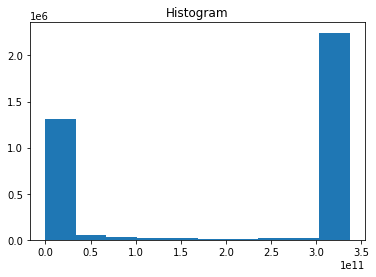

In [34]:
heat.plot()

The above method produced a histogram of heat values because you have data in 2 spatial dimensions and 1 in time. 

Let's one point in time using Xarray's `isel` method. `isel` refers to index-select and allows you to name the dimension in which you are subselecting. Read more about indexing and selecting data from an Xarray DataSet [here](http://xarray.pydata.org/en/stable/indexing.html).

In [35]:
heat_time0 = heat.isel(time=0)
heat_time0

<xarray.DataArray (lat: 180, lon: 288)>
dask.array<getitem, shape=(180, 288), dtype=float64, chunksize=(180, 288), chunktype=numpy.ndarray>
Coordinates:
    time     object 1850-01-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

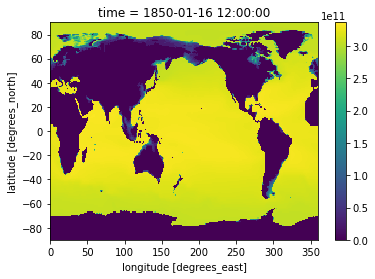

In [36]:
heat_time0.plot()

`isel` is in contrast to `.sel` which allows you to select data by value.

Below we look for data between January and February in the year 1851:

In [37]:
heat_Jan_1851 = heat.sel(time=slice('1851-01-01','1851-02-01')).squeeze('time')
heat_Jan_1851

<xarray.DataArray (lat: 180, lon: 288)>
dask.array<getitem, shape=(180, 288), dtype=float64, chunksize=(180, 288), chunktype=numpy.ndarray>
Coordinates:
    time     object 1851-01-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4

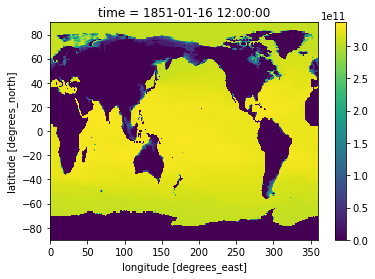

In [38]:
heat_Jan_1851.plot()

Let's use subplots to plot both timestamps of these side by side.

To do this you will need to import matploblib, a [package](https://matplotlib.org/) for plotting.

In [39]:
import matplotlib.pyplot as plt

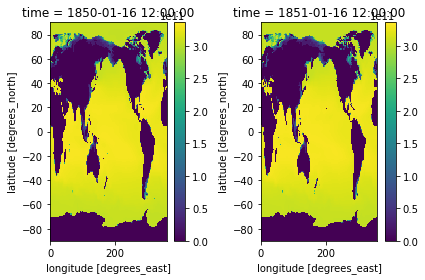

In [40]:
fig, axes = plt.subplots(ncols=2)
heat_time0.plot(ax=axes[0])
heat_Jan_1851.plot(ax=axes[1])
plt.tight_layout()

Use the `cmap` to change your color map. I will use a different color map for each example to demonstrate some options. Be sure to follow [guidelines](https://seaborn.pydata.org/tutorial/color_palettes.html) about selecting good colormaps. 

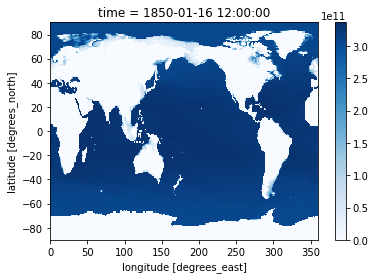

In [41]:
heat_time0.plot(cmap='Blues')

Xarray is intelligent about attributes in plotting. If we add units, our colorbar will automatically be labeled. 

Let's specify a units attribute for our heat values:

In [42]:
heat_time0.attrs['units'] = 'Joules/K'
heat_Jan_1851.attrs['units'] = 'Joules/K'

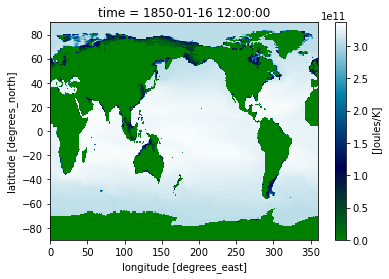

In [43]:
heat_time0.plot(cmap='ocean')

Perhaps you want the contour plot to have discrete levels. You can do this by specifying the number of levels like-so:

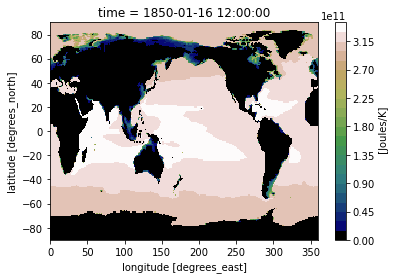

In [44]:
heat_time0.plot(cmap='gist_earth', levels=30)

Or you can specify the space and color of each level:

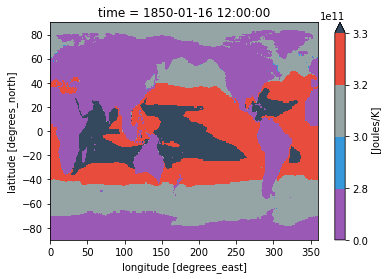

In [45]:
levels = [0, 2.8e11, 3e11, 3.2e11, 3.3e11]
level_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
heat_time0.plot(levels=levels, colors=level_colors)

If you want to plot multiple plots on the same colorbar, it is useful to normalize your colorbar. Some options are matplotlib's `colors.Normalize`, `colors.BoundaryNorm`, and `colors.LogNorm` which allows you to put your data on a logarithmic color bar. Read about colormap normalization [here](https://matplotlib.org/users/colormapnorms.html). 

In [46]:
from matplotlib import colors

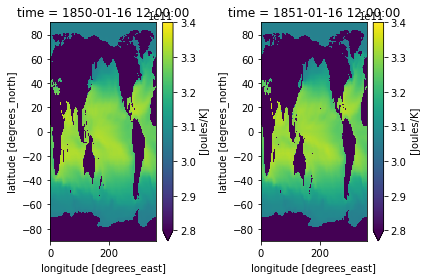

In [47]:
cmin = 2.8e11
cmax = 3.4e11
cnorm = colors.Normalize(cmin, cmax)

fig, axes = plt.subplots(ncols=2)
heat_time0.plot(ax=axes[0], norm=cnorm)
heat_Jan_1851.plot(ax=axes[1], norm=cnorm)
plt.tight_layout()

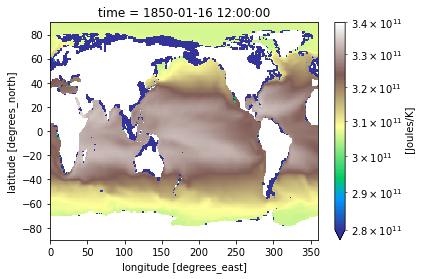

In [48]:
cmin = 2.8e11
cmax = 3.4e11
cnorm = colors.LogNorm(cmin, cmax)

heat_time0.plot(norm=cnorm, cmap='terrain')

Maybe you want to plot the difference between two time stamps and pick a diverging colormap for positive and negative differences.

In [49]:
heat_diff = heat_time0 - heat_Jan_1851
heat_diff.attrs['units'] = 'Joules/K'
heat_diff

<xarray.DataArray (lat: 180, lon: 288)>
dask.array<sub, shape=(180, 288), dtype=float64, chunksize=(180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
Attributes:
    units:    Joules/K

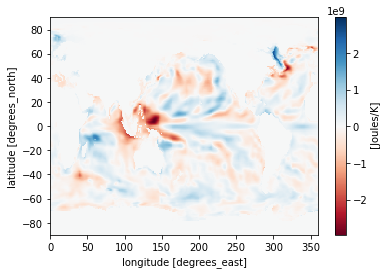

In [50]:
heat_diff.plot(cmap='RdBu')

Wouldn't it be nice to see land borders on the above plot?

We can use [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) for this!

In [51]:
import cartopy.crs as ccrs

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


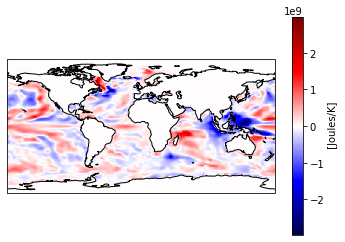

In [52]:
# This may take some time on low-memory computers
#
ax = plt.axes(projection=ccrs.PlateCarree())
heat_diff.plot(ax=ax, cmap='seismic')
ax.set_global() 
ax.coastlines()

Or you can use different projections!

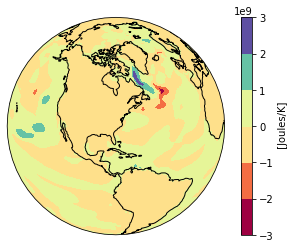

In [53]:
# This may take some time on low-memory computers
#
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
heat_diff.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap='Spectral')
ax.set_global()
ax.coastlines()

There are many ways to manipulate visualizations in Python. For more examples visit some of our other notebooks.